# Simple Customer Insights
_version 0.5_

January 28, 2016
https://developer.ibm.com/clouddataservices/


## Overview

Today, an ever growing wealth of public data, e.g. census, geospatial, demographic, incident, traffic, etc., is available to fuel analytic insights when combined with corporate data. Your own data only tells you what your business is doing. With open data, you learn what the world is doing. And the combination of the two allows you to align business practices with the market.

**Simple Customer Insights** is about democratizing big data analytics with open data and cloud-based analytics. It's a [Jupyter notebook](http://jupyter.org/) that runs best in [IBM's Spark-as-a-service](http://www.ibm.com/analytics/us/en/technology/cloud-data-services/spark-as-a-service/) that enables a Bluemix user to integrate customer sales data with US Census demographic data, and in minutes perform common analyses that once took days or weeks to complete.

This notebook goes through a complete analysis using sample data readily available on the web. But it also serves as a template for your own work with your own data. Just substitute the sample sales data with your own! 

Here are some of the insights produced in this notebook:
1. demographic characteristics of good customers
1. most important demographic characteristics in understanding product appeal
1. location of places that are like those areas currently enjoying strong sales

## Table of Contents

- [Setup](#setup)
- [Census Data](#censusdata)
  - [Census data description](#censusdatadesc)
  - [Import](#censusdataimport)
  - [Descriptive statistics](#censusdatastats)
- [Sales data](#salesdata)
  - [Import](#salesdataimport)
  - [Merge with Census](#salesdatamerge)
- [Insights](#insights)
  - [Visualization](#viz)
  - [Analysis](#analysis)
- [Finding high potential zip codes](#zipfind)
- [Mapping](#map)

<a id="setup"></a>
## Setup 

### Python Imports
Import libraries and connection information to connect to Swift Object Storage on IBM Bluemix to get data from CSV text files. 

In [1]:
import os, requests, StringIO, pandas as pd, numpy as np, json, matplotlib.pyplot as plt, seaborn as sns

/Users/rajrsingh/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
credentials = {}
credentials['auth_url'] = 'https://identity.open.softlayer.com'
credentials['user_id'] = os.environ['OBJECTSTORE_USER_ID']
credentials['domain_id'] = os.environ['OBJECTSTORE_DOMAIN_ID']
credentials['username'] = os.environ['OBJECTSTORE_USERNAME']
credentials['password'] = os.environ['OBJECTSTORE_PASSWORD']
credentials['container'] = os.environ['OBJECTSTORE_CONTAINER']

### ObjectStore credentials

My working environment is set up to get my ObjectStore credentials above from variables I've set at the operating system level. You may want to go a simpler route and just enter the values as strings above. And when you copy this notebook to the [IBM Analytics for Apache Spark service](https://console.ng.bluemix.net/catalog/services/apache-spark/?cm_mmc=developerWorks-_-dWdevcenter-_-clouddataservices-_-lp), embedding your credentials directly in the notebook is your only option. You can find your ObjectStore credentials by finding your instance of the ObjectStore service in Bluemix and clicking on the 'Service Credentials'.

![ObjectStore credentials](https://raw.githubusercontent.com/ibm-cds-labs/open-data/master/samples/img/objectstore_creds.png "ObjectStore credentials")

In [3]:
# A function returning a StringIO object containing text file content from Object Storage.

def getFileContent(credentials):
    url1 = ''.join([credentials['auth_url'], '/v3/auth/tokens'])
    data = {'auth': 
            {'identity': 
             {'methods': ['password'],
              'password': {
                    'user': 
                    {'name': credentials['username'],
                     'domain': {'id': credentials['domain_id']},
                     'password': credentials['password']
                    }
               }
              }
             }
            }
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()    
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                if(e2['interface']=='public'):
                    url2 = ''.join([e2['url'],'/', 
                                    credentials['container'], '/', 
                                    credentials['filename']])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.get(url=url2, headers=headers2)
    return StringIO.StringIO(resp2.content)

<a id="censusdata"></a>
## Census data

Census data from the 2013 US Census American Community Survey (ACS), 5-year estimates. 

Created from the "zip code tabulation area" (ZCTA) [TIGER/Line® with Selected Demographic and Economic Data product in Geodatabase format](http://www.census.gov/geo/maps-data/data/tiger-data.html). This particular version of the ACS is used for the folowing reasons:
1. 5-year estimates are the most accurate data outside of the decennial census [as explained here](http://www.census.gov/programs-surveys/acs/guidance/estimates.html).
1. 2013 is the most recent data set with 5-year estimates
1. TIGER/Line® gives you the geographic boundaries of the zip codes so you can perform spatial analyses
1. This data set is smaller than the full Census, but still has the important income, education, race, age and occupation demographics we want to use.

If you want to do this yourself, [this article](https://developer.ibm.com/clouddataservices/2015/09/08/census-open-data-on-ibm-cloud/) explains how to get a CSV out of that format. 

<a id="censusdatadesc"></a>
### Census data description

Here are the data fields we will use from the Census

```
GEOID: Zip code
```

### Income
```
B19049e1: Median household income
```

#### Age
```
B01002e1: Median age
```

#### Educational attainment (population >= 25 years old)
```
B15003e1: Total population
B15003e2: No schooling completed
B15003e3: Nursery school
B15003e4 to B15003e16: Kindergarten to 12th grade
B15003e17: Regular high school diploma
B15003e18: GED or alternative
B15003e19: Some college, < 1 year
B15003e20: Some college, 1 or more years, no degree
B15003e21: Associates degree
B15003e22: Bachelors degree
B15003e23: Masters degree
B15003e24: Professional degree
B15003e25: Doctorate degree
```

#### Race
```
B02001e1: Total population
B02001e2: White alone
B02001e3: Black or African American alone
B02001e4: American Indian and Alaska Native alone
B02001e5: Asian alone
B02001e6: Native Hawaiian and Other Pacific Islander alone
B02001e7: Some other race alone
B02001e8: Two or more races
B03001e3: Hispanic or Latino: Total population
```

<a id="censusdataimport"></a>
### Import Census data

In [4]:
#credentials['filename'] = 'sci.csv'
#raw_data = getFileContent(credentials)

In [5]:
raw_data = "/Users/rajrsingh/Desktop/csv/outfiles/sci.csv.gz"
census_df = pd.read_csv(raw_data, usecols=['GEOID','B19049e1','B01002e1',
                                           'B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6','B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13','B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20','B15003e21','B15003e22','B15003e23','B15003e24','B15003e25',
                                           'B02001e1','B02001e2','B02001e3','B02001e4','B02001e5','B02001e6','B02001e7','B02001e8','B03001e3'])

Group educational attainment into 4 major categories, and normalize by making it a percentage of the zip code's population

In [6]:
census_df['INCOME'] = census_df['B19049e1']
census_df['AGE'] = census_df['B01002e1']
census_df.drop(['B19049e1','B01002e1'],inplace=True,axis=1)

census_df['NOHSDIP'] = (census_df['B15003e2']+census_df['B15003e3']+census_df['B15003e4']+census_df['B15003e5']+census_df['B15003e6']+census_df['B15003e7']+census_df['B15003e8']+census_df['B15003e9']+census_df['B15003e10']+census_df['B15003e11']+census_df['B15003e12']+census_df['B15003e13']+census_df['B15003e14']+census_df['B15003e15']+census_df['B15003e16'])/census_df['B15003e1']
census_df['HSDIPSOMECOL'] = (census_df['B15003e17']+census_df['B15003e18']+census_df['B15003e19']+census_df['B15003e20']+census_df['B15003e21'])/census_df['B15003e1']
census_df['BA'] = census_df['B15003e22']/census_df['B15003e1']
census_df['GRAD'] = (census_df['B15003e23']+census_df['B15003e24']+census_df['B15003e25'])/census_df['B15003e1']
census_df['POPULATION'] = census_df['B15003e1']

census_df['WHITE'] = census_df['B02001e2']/census_df['B02001e1']
census_df['BLACK'] = census_df['B02001e3']/census_df['B02001e1']
census_df['NATAMER'] = census_df['B02001e4']/census_df['B02001e1']
census_df['ASIAN'] = census_df['B02001e5']/census_df['B02001e1']
census_df['PACISL'] = census_df['B02001e6']/census_df['B02001e1']
census_df['OTHERRACE'] = census_df['B02001e7']/census_df['B02001e1']
census_df['MULTIRACE'] = census_df['B02001e8']/census_df['B02001e1']
census_df['HISPLAT'] = census_df['B03001e3']/census_df['B02001e1']
census_df.drop(['B02001e1','B02001e2','B02001e3','B02001e4','B02001e5','B02001e6','B02001e7','B02001e8','B03001e3'],inplace=True,axis=1)

census_df = census_df.set_index('GEOID')
census_df.head()

,B15003e1,B15003e2,B15003e3,B15003e4,B15003e5,B15003e6,B15003e7,B15003e8,B15003e9,B15003e10,...,GRAD,POPULATION,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
GEOID,,,,,,,,,,,,,,,,,,,,,
86000US01001,12417,28,0,0,6,0,0,16,11,18,...,0.096158,12417,0.922586,0.011772,0.001392,0.027022,0.001566,0.025515,0.010148,0.053291
86000US01002,12846,186,12,0,0,5,26,8,58,15,...,0.430406,12846,0.807046,0.044728,0.004271,0.108351,0.000000,0.005023,0.030582,0.075856
86000US01003,233,0,0,0,0,0,0,0,0,0,...,0.133047,233,0.810642,0.060914,0.000000,0.110950,0.001360,0.006617,0.009518,0.049130
86000US01005,3527,23,0,0,0,0,0,0,63,0,...,0.080805,3527,0.976662,0.003361,0.001120,0.018857,0.000000,0.000000,0.000000,0.015310
86000US01007,10126,34,0,0,0,0,0,0,0,0,...,0.152281,10126,0.932325,0.017651,0.000000,0.023308,0.000000,0.004634,0.022081,0.029783


In [7]:
# Compute national averages

nat_edu_nohsdip = census_df['B15003e2'].sum()+census_df['B15003e3'].sum()+census_df['B15003e4'].sum()+census_df['B15003e5'].sum()+census_df['B15003e6'].sum()+census_df['B15003e7'].sum()+census_df['B15003e8'].sum()+census_df['B15003e9'].sum()+census_df['B15003e10'].sum()+census_df['B15003e11'].sum()+census_df['B15003e12'].sum()+census_df['B15003e13'].sum()+census_df['B15003e14'].sum()+census_df['B15003e15'].sum()+census_df['B15003e16'].sum()
nat_edu_hsdipsomecol = census_df['B15003e17'].sum()+census_df['B15003e18'].sum()+census_df['B15003e19'].sum()+census_df['B15003e20'].sum()+census_df['B15003e21'].sum()
nat_edu_ba = census_df['B15003e22'].sum()
nat_edu_grad = census_df['B15003e23'].sum()+census_df['B15003e24'].sum()+census_df['B15003e25'].sum()
census_df_national = pd.DataFrame( [ {'NOHSDIP': nat_edu_nohsdip, 'HSDIPSOMECOL': nat_edu_hsdipsomecol, 'BA': nat_edu_ba, 'GRAD': nat_edu_grad, 'POPULATION': census_df['B15003e1'].sum()} ] )

# Now safely drop unneeded original data columns
census_df.drop(['B15003e1','B15003e2','B15003e3','B15003e4','B15003e5','B15003e6','B15003e7','B15003e8','B15003e9','B15003e10','B15003e11','B15003e12','B15003e13','B15003e14','B15003e15','B15003e16','B15003e17','B15003e18','B15003e19','B15003e20','B15003e21','B15003e22','B15003e23','B15003e24','B15003e25'],inplace=True,axis=1)

census_df_national_rate = census_df_national.truediv(census_df_national['POPULATION'], axis=0)
census_df_national_rate #will be used later

,BA,GRAD,HSDIPSOMECOL,NOHSDIP,POPULATION
0,0.18049,0.107933,0.571749,0.139828,1


<a id="censusdatastats"></a>
### Descriptive statistics for Census data

### Summary statistics

In [8]:
summary_df = census_df.describe(percentiles=[0.4,0.5,0.6])
summary_df = summary_df.drop(summary_df.index[[0,2]])
summary_df

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,POPULATION,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
mean,52112.585863,41.495351,0.142982,0.635888,0.141745,0.079385,6262.068235,0.841515,0.076411,0.017566,0.019763,0.001062,0.021783,0.021899,0.084829
min,2499.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,43864.000000,39.400000,0.098551,0.629885,0.101979,0.044529,1121.000000,0.888687,0.003023,0.000000,0.000000,0.000000,0.000000,0.009633,0.016256
50%,47778.000000,41.100000,0.118819,0.658076,0.120989,0.055047,1885.000000,0.929005,0.008680,0.000930,0.002520,0.000000,0.002613,0.013994,0.026227
60%,52031.000000,42.900000,0.143008,0.683938,0.142688,0.067751,3337.800000,0.954310,0.019099,0.002237,0.005837,0.000000,0.006331,0.018782,0.040488
max,250001.000000,91.500000,1.000000,1.000000,1.000000,1.000000,73169.000000,1.000000,1.000000,1.000000,1.000000,0.610088,1.000000,1.000000,1.000000


#### Examining correlation

In this section, we take a quick look at the correlation coefficients of many of our variables of interest to make sure it's worth looking at each one separately. This function computes the [Pearson product-moment correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient), which looks at two variables and computes a number between -1 and 1, where -1 is perfect negative correlation, 1 is perfect positive correlation, and 0 is no correlation. 

None of our variables of interest have a particularly strong correlation with each other (except for the obvious ones like income with bachelor's (BA) or graduate degree (GRAD)), so we can proceed with analysis knowing that it's worth looking at all of them. 

In [9]:
census_df.corr()

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,POPULATION,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
INCOME,1.000000,0.019283,-0.493704,-0.403501,0.612801,0.608495,0.178891,0.133290,-0.198328,-0.105948,0.316532,0.007710,-0.056600,0.013031,-0.059277
AGE,0.019283,1.000000,-0.132785,0.101687,-0.012931,0.014904,-0.266181,0.343371,-0.202765,-0.135526,-0.157964,-0.041132,-0.233473,-0.139086,-0.285101
NOHSDIP,-0.493704,-0.132785,1.000000,-0.188873,-0.494164,-0.393269,-0.020282,-0.271457,0.222353,0.097679,-0.094619,-0.008707,0.308963,-0.006511,0.374778
HSDIPSOMECOL,-0.403501,0.101687,-0.188873,1.000000,-0.647732,-0.679238,-0.316416,0.200404,-0.086157,0.043879,-0.363412,-0.007114,-0.201873,-0.049185,-0.243569
BA,0.612801,-0.012931,-0.494164,-0.647732,1.000000,0.554777,0.274165,0.025670,-0.084107,-0.102451,0.336811,0.017371,-0.030838,0.044005,-0.032637
GRAD,0.608495,0.014904,-0.393269,-0.679238,0.554777,1.000000,0.237045,-0.016970,-0.043357,-0.079743,0.338609,0.002832,-0.022916,0.039553,-0.035593
POPULATION,0.178891,-0.266181,-0.020282,-0.316416,0.274165,0.237045,1.000000,-0.320324,0.200520,-0.074026,0.391102,0.041310,0.295136,0.116616,0.332683
WHITE,0.133290,0.343371,-0.271457,0.200404,0.025670,-0.016970,-0.320324,1.000000,-0.762096,-0.396899,-0.333107,-0.138006,-0.355111,-0.303079,-0.253063
BLACK,-0.198328,-0.202765,0.222353,-0.086157,-0.084107,-0.043357,0.200520,-0.762096,1.000000,-0.062498,0.015115,-0.019454,0.054918,0.004964,0.019785
NATAMER,-0.105948,-0.135526,0.097679,0.043879,-0.102451,-0.079743,-0.074026,-0.396899,-0.062498,1.000000,-0.036464,0.018238,-0.023622,0.093660,-0.025517


<a id="salesdata"></a>
## Sales data

<a id="salesdataimport"></a>
### Import sample sales data set

Here we bring in a relatively small sample sales data set. There are only about 400 U.S. sales for the product we are interested in -- "Product1". But this is good enough to illustrate the analysis. 

If you were to do this yourself with your own sales data, your data should organized as follows:
1. there should be sales in the U.S. (since we're analyzing it against U.S. Census data)
1. each row should represent a unique sale
1. the data set should contain columns for zip code, price, product ID and Country name
1. the data set should be in a CSV text file format

In [10]:
credentials['filename'] = 'SalesJan2009.csv'
country = 'United States'
product = 'Product1'

# import the CSV file
#raw_data = getFileContent(credentials)
raw_data = "/Users/rajrsingh/Box Sync/CDS/Developer Advocacy/Open Data/sales2009/SalesJan2009.csv"

# create a data frame with just the columns we need
sales_df = pd.read_csv(raw_data, dtype={"US Zip": np.str}, 
                       usecols=['Product','US Zip','Country'])

# just get US sales for a single product
sales_df = sales_df[ (sales_df.Product == product) 
                      & (sales_df.Country == country)]

# make the zip code format match the zip code format in the census data
sales_df['GEOID'] = "86000US" + sales_df['US Zip']

# drop columns we don't need anymore
sales_df.drop(['Product','Country','US Zip'],inplace=True,axis=1)

In [11]:
sales_counts = sales_df['GEOID'].value_counts()
sales_counts.name = 'Sales'
sales_counts.describe()

count    306.000000
mean       1.307190
std        0.866733
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        9.000000
Name: Sales, dtype: float64

<a id="salesdatamerge"></a>
### Merge sales to Census

In [12]:
saleszips = census_df.join(sales_counts, how='right')
saleszips['Zip'] = saleszips.index
saleszips.describe(percentiles=[0.4,0.5,0.6])

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,POPULATION,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT,Sales
count,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,305.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,304.000000,306.000000
mean,76178.167763,39.015132,0.100072,0.472995,0.246166,0.180768,17508.301639,0.760876,0.093561,0.005064,0.072316,0.002496,0.036198,0.029490,0.134404,1.307190
std,36094.736528,6.057036,0.083413,0.148536,0.093341,0.115888,11111.128358,0.193980,0.144929,0.012988,0.090579,0.011741,0.056148,0.031175,0.151961,0.866733
min,16069.000000,21.800000,0.000000,0.040559,0.000000,0.010708,0.000000,0.095601,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
40%,62186.000000,37.400000,0.058791,0.436068,0.220465,0.124059,13572.800000,0.783673,0.025167,0.001416,0.027078,0.000000,0.011289,0.020066,0.060033,1.000000
50%,69855.500000,38.650000,0.074362,0.478094,0.247006,0.159859,16488.000000,0.819666,0.035619,0.002246,0.038763,0.000000,0.015675,0.023534,0.076052,1.000000
60%,79873.600000,40.600000,0.092572,0.531858,0.279242,0.192510,19351.800000,0.857119,0.054711,0.002938,0.056001,0.000132,0.022228,0.027695,0.104562,1.000000
max,216037.000000,68.300000,0.553417,0.769231,0.440627,0.656643,65117.000000,0.994135,0.767693,0.136069,0.488290,0.115780,0.385442,0.271421,0.887213,9.000000


### Identify sales zips with strongest correlation to customers

e.g. zips with at least 2 sales - or the top 75% of zips with sales

In [13]:
# 25% threshold is 1, so select zips with sales > 1
highsaleszips = saleszips[ ( saleszips.Sales > 1)]
highsaleszipssum_df = highsaleszips.describe(percentiles=[.40,.50,.60])
highsaleszipssum_df = highsaleszipssum_df.drop(highsaleszipssum_df.index[[0,2]])
highsaleszipssum_df.drop(['Sales'],inplace=True,axis=1)
highsaleszipssum_df

,INCOME,AGE,NOHSDIP,HSDIPSOMECOL,BA,GRAD,POPULATION,WHITE,BLACK,NATAMER,ASIAN,PACISL,OTHERRACE,MULTIRACE,HISPLAT
mean,76031.980769,37.85,0.116458,0.416471,0.261879,0.205191,17283.132075,0.699061,0.123149,0.006745,0.089312,0.003743,0.045753,0.032236,0.171723
min,22401.000000,29.90,0.000000,0.040559,0.000000,0.016456,0.000000,0.095601,0.003826,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
40%,56963.600000,35.58,0.064051,0.396659,0.239548,0.156830,12456.400000,0.725771,0.055825,0.001435,0.037337,0.000000,0.018347,0.021595,0.077678
50%,69728.500000,37.80,0.077361,0.424456,0.274037,0.178124,16354.000000,0.766824,0.080367,0.002208,0.054002,0.000000,0.021491,0.027897,0.104359
60%,81812.000000,39.26,0.097105,0.450315,0.307510,0.209332,18323.800000,0.796342,0.101325,0.002779,0.072390,0.000265,0.025422,0.030893,0.123695
max,216037.000000,55.60,0.417073,0.769231,0.440627,0.656643,65117.000000,0.989341,0.760590,0.136069,0.488290,0.104259,0.384390,0.191157,0.887213


<a id="insights"></a>
## Insights

<a id="viz"></a>
### Visualization

In [14]:
%matplotlib inline

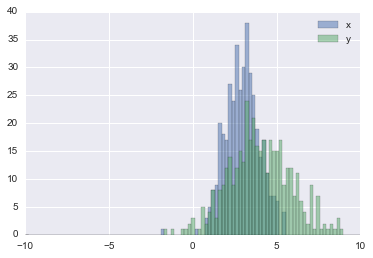

In [15]:
import random
import numpy
from matplotlib import pyplot

x = [random.gauss(3,1) for _ in range(400)]
y = [random.gauss(4,2) for _ in range(400)]

bins = numpy.linspace(-10, 10, 100)

pyplot.hist(x, bins, alpha=0.5, label='x')
pyplot.hist(y, bins, alpha=0.5, label='y')
pyplot.legend(loc='upper right')
pyplot.show()

NameError: name 'ax1' is not defined

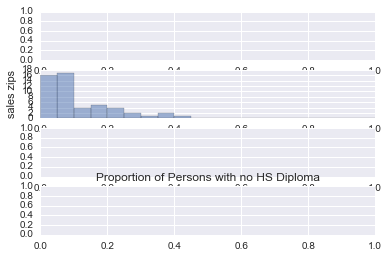

In [16]:
common_params = dict(bins=20, alpha=0.5,
                     range=(0.0,1.0))

fig, axs = plt.subplots(4,1)
plt.title('Proportion of Persons with no HS Diploma')
axs[1].set_ylabel('sales zips')
axs[1].hist(highsaleszips['NOHSDIP'], label='Sales Zips', **common_params)

axs[2] = ax1.twinx()
axs[2].set_ylabel('nation')
axs[2].hist(census_df['NOHSDIP'], label='Nation', histtype='step', linewidth=3, color='green', **common_params)

plt.legend(loc='upper right')
plt.show()

In [ ]:
fig, axs = plt.subplots(4,1)

highsaleszips['NOHSDIP'].plot(kind='bar', ax=axs[0], figsize=(12,8), title='Education in sales areas')
axs[0].set_xticklabels('')
axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[0].axhline(y=census_df_national_rate['NOHSDIP'], xmin=0.0, xmax=1.0, linewidth=2, color = 'k')

highsaleszips['HSDIPSOMECOL'].plot(kind='bar', color='gold', ax=axs[1], figsize=(12,8))
axs[1].set_xticklabels('')
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[1].axhline(y=census_df_national_rate['HSDIPSOMECOL'], xmin=0.0, xmax=1.0, linewidth=2, color = 'k')

highsaleszips['BA'].plot(kind='bar', color='green', ax=axs[2], figsize=(12,8))
axs[2].set_xticklabels('')
axs[2].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[2].axhline(y=census_df_national_rate['BA'], xmin=0.0, xmax=1.0, linewidth=2, color = 'k')

highsaleszips['GRAD'].plot(kind='bar', color='purple', ax=axs[3], figsize=(12,8))
axs[3].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
axs[3].axhline(y=census_df_national_rate['GRAD'], xmin=0.0, xmax=1.0, linewidth=2, color = 'k')


#### Demographics Histograms

In [ ]:
plt.subplots_adjust(hspace=.4)
common_params = dict(bins=20, range=(0.0,0.5))
#common_params['histtype'] = 'step'

plt.figure(1)
plt.subplot(2, 1, 1)
plt.title('Sales zips Proportion of Persons with no HS Diploma')
plt.hist(highsaleszips['NOHSDIP'], **common_params)
plt.subplot(2, 1, 2)
plt.title('National Proportion of Persons with no HS Diploma')
plt.hist(census_df['NOHSDIP'], **common_params)

#census_df['NOHSDIP'].plot(kind='hist', bins=20, range=(0.0,0.5), figsize=(12,4), title='Proportion of Persons with no HS Diploma')


In [ ]:
df4 = pd.DataFrame({'a': np.random.randn(1000) + 1, 'b': np.random.randn(1000),
                    'c': np.random.randn(1000) - 1}, columns=['a', 'b', 'c'])
df4.sample(5)

In [ ]:
sns.set_style("whitegrid")
sns.set_palette( sns.hls_palette(n_colors=7) )
highsaleszips.hist(bins=20, figsize=(16,16), column=['INCOME','AGE','NOHSDIP','HSDIPSOMECOL','BA','GRAD','WHITE','BLACK','NATAMER','ASIAN','PACISL','OTHERRACE','MULTIRACE','HISPLAT'])

#### Education levels for zip codes in which we have sales

In [ ]:
highsaleszips.loc[:,'NOHSDIP':'GRAD'].plot(kind='bar', stacked=True, figsize=(12,8), title='Education in sales areas')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Major racial groups for zip codes in which we have sales

In [ ]:
highsaleszips.loc[:,'WHITE':'ASIAN'].plot(kind='bar', stacked=True, figsize=(12,8), title='Race in sales areas')
plt.ylim(0, 1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
# Compare characteristics of the country as a whole to zip codes with sales
salesdiff_df = highsaleszipssum_df.sub(summary_df)
salesdiff_df

<a id="analysis"></a>
### Analysis

#### Incomes are much higher
Median household income overall is about $22,000 higher than the country as a whole, which is **very** significant as that represents a nearly 50% increase in income in these zip codes we sell to.

#### Education is greater
The percentage of people with high school diplomas but no college degree is almost 24% lower in our sales zips, and that is compensated by a much greater number of college grads (16% higher) and people with graduate degrees of some sort (12% higher). 

#### People are a little younger
Males and females are about 3 1/2 years younger in our zip codes than in the country as a whole.


#### White population is lower
The white population is lower, and there is a corresponding higher number of other races.



<a id="zipfind"></a>
## Finding high potential zip codes

Here we take the variables we found to best explain the population of sales areas, and we look for other zip codes whose demographic characteristics for those variables are within 10 percentage points of the median. 

In [ ]:
censusgood_df = census_df [
    ( census_df.INCOME > highsaleszipssum_df.loc['40%','INCOME'] )
    & ( census_df.INCOME < highsaleszipssum_df.loc['60%','INCOME'] )
    & ( census_df.AGE > highsaleszipssum_df.loc['40%','AGE'] )
    & ( census_df.AGE < highsaleszipssum_df.loc['60%','AGE'] )
    & ( census_df.BA > highsaleszipssum_df.loc['40%','BA'] )
    & ( census_df.BA < highsaleszipssum_df.loc['60%','BA'] )
    & ( census_df.WHITE > highsaleszipssum_df.loc['40%','WHITE'] )
    & ( census_df.WHITE < highsaleszipssum_df.loc['60%','WHITE'] )
    ]
censusgood_df.describe()

### Target regions

Here we list the matching zip codes. From this point you could use this list in a variety of ways. Here are some ideas: 
- Guidance for where to spend marketing dollars
- Filter existing direct mail lists to target those most likely to buy
- Guidance on where to build retail outlets, or if you're a wholesaler, where you want to get your products retailed.

In [ ]:
censusgood_df.index.tolist()

<a id="map"></a>
## Mapping great prospective zip codes with CartoDB

Having a list of zip codes is great, but it's extremely useful to be able to see the results on a map. This is the best way to do a 'reality check' and see if the results make sense. It's also interesting to survey the country in this way -- a birds-eye view of where your product is selling and where there's potential demand. 

Here we show an integration with a good friend of ours, CartoDB. CartoDB is a firm specializing in mapping-as-a-service. They use the excellent open source database, PostgreSQL and it's geospatial extension, PostGIS to power their service. 

What we need to do to dynamically create maps of our analytics results is:
1. Manually import the raw census zip code boundaries into CartoDB's platform (with no demographic data attached to reduce the file size)
1. Create a map in CartoDB of the zip code boundaries
1. Add 2 empty tables to the map that represent zip codes with sales, and good potential zip codes
1. When we run an analysis, populate those tables with the results of the analysis

### Update data tables in CartoDB

In [ ]:
#!pip install --user cartodb
# Set up cartodb module for use
from cartodb import CartoDBAPIKey, CartoDBException
API_KEY = os.environ['CARTODB_APIKEY']
CARTODB_ACCOUNT = os.environ['CARTODB_ACCOUNT']
cl = CartoDBAPIKey(API_KEY, CARTODB_ACCOUNT)

#### Update Sales table in CartoDB

In [ ]:
# output good Census zips to a list
ziplist = highsaleszips.index.tolist()

In [ ]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO highsaleszips(zipcode) VALUES ('%s')" %x, ziplist))

In [ ]:
# update sales table
try:
    print(cl.sql('delete from highsaleszips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

#### Update prospective zip codes  in CartoDB

In [ ]:
# output good Census zips to a list
ziplist = censusgood_df.index.tolist()

In [ ]:
# generate PostgreSQL INSERT statements for CartoDB
insertsql = ';'.join(map(lambda x: "INSERT INTO prospectzips(zipcode) VALUES ('%s')" %x, ziplist))

In [ ]:
try:
    print(cl.sql('delete from prospectzips'))
    print(cl.sql(insertsql))
except CartoDBException as e:
    print("some error ocurred", e)

## Display the dynamic map 

In [ ]:
%%javascript
element.append("<link rel='stylesheet' href='http://libs.cartocdn.com/cartodb.js/v3/3.15/themes/css/cartodb.css' />")
element.append("<div id='map' style='height:500px;width:900px;padding:0;margin:0'></div>");

require.config({
  paths: {
      cartodblib: 'http://libs.cartocdn.com/cartodb.js/v3/3.15/cartodb'
  }
});

var main = function() {
  // from map: https://ibmanalytics.cartodb.com/u/ibm/viz/2bd6ea76-9f7f-11e5-a024-0e674067d321/map
  cartodb.createVis('map', 'https://ibmanalytics.cartodb.com/u/ibm/api/v2/viz/2bd6ea76-9f7f-11e5-a024-0e674067d321/viz.json', {
      shareable: true,title: true,description: true,search: true,tiles_loader: true,
      center_lat: 40, center_lon: -100, zoom: 3
  })
  .done(function(vis, layers) {
    console.log('here');
    // layer 0 is the base layer, layer 1 is cartodb layer
    // setInteraction is disabled by default
    layers[1].setInteraction(true);
    layers[1].on('featureOver', function(e, latlng, pos, data) {
      cartodb.log.log(e, latlng, pos, data);
    });
    
    var map = vis.getNativeMap(); // get the native map to work with it
    
  })
  .error(function(err) {
    console.log(err);
  });
}

require(['cartodblib'], main);


## The end